In [4]:
# import packages
import numpy as np
import pandas as pd
import wooldridge as woo
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import patsy as pt
import scipy.stats as stats
import matplotlib.pyplot as plt
import linearmodels as plm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white
from statsmodels.stats.outliers_influence import variance_inflation_factor
import linearmodels.iv as iv
import statsmodels.base.model as smclass
from prettytable import PrettyTable

In [5]:
df = pd.read_csv('/Users/zoeyroberts/Documents/Spring 2022/Econs 525/Rhino Tourism Dataset.csv', \
                usecols = ['country', 'code', 'year', 'electric', 'exchangerate', 'fdi', \
                           'gdpcapita', 'immunization', 'rhinos', 'rural', 'stability', \
                           'tourism', 'trade', 'hdi'])
df = df.set_index(['country', 'year'], drop=False)
print(df)

                country  code  year   electric  exchangerate       fdi  \
country  year                                                            
kenya    2006     kenya     1  2006  26.553055  7.210084e+01  7.625776   
         2007     kenya     1  2007  28.426634  6.731667e+01  7.570348   
         2008     kenya     1  2008  30.303398  6.917583e+01  8.718309   
         2009     kenya     1  2009  23.000000  7.735083e+01  9.274714   
         2010     kenya     1  2010  19.200000  7.923333e+01  2.515270   
...                 ...   ...   ...        ...           ...       ...   
zimbabwe 2014  zimbabwe     5  2014  32.300000  1.222375e+08  2.425173   
         2015  zimbabwe     5  2015  33.700000  1.222375e+08  1.999687   
         2016  zimbabwe     5  2016  39.676228  1.222375e+08  1.669274   
         2017  zimbabwe     5  2017  40.144283  1.222375e+08  1.746885   
         2018  zimbabwe     5  2018  40.616360  1.222375e+08  3.962704   

               gdpcapita    hdi  immu

In [6]:
X = df[['electric', 'exchangerate', 'fdi', 'gdpcapita', 'hdi', 'immunization', 'rhinos', \
        'rural', 'stability', 'trade']]
vif = pd.DataFrame()
vif["variable"] = X.columns

vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

       variable         VIF
0      electric   76.987028
1  exchangerate    1.391113
2           fdi    2.847935
3     gdpcapita    6.959405
4           hdi  420.189658
5  immunization  257.998123
6        rhinos    3.246478
7         rural  116.914979
8     stability    2.908917
9         trade   18.131484


In [7]:
df['development'] = df['immunization'] + df['hdi'] + df['rural']
X = df[['electric', 'exchangerate', 'fdi', 'gdpcapita', 'development', 'rhinos', 'stability', 'trade']]
vif = pd.DataFrame()
vif["variable"] = X.columns

vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif)

       variable        VIF
0      electric   9.949912
1  exchangerate   1.319286
2           fdi   2.639204
3     gdpcapita   3.391395
4   development  24.966208
5        rhinos   2.658765
6     stability   2.609849
7         trade  18.123526


In [8]:
X = df[['electric', 'exchangerate', 'fdi', 'gdpcapita', 'rhinos', 'stability', 'trade']]
vif = pd.DataFrame()
vif["variable"] = X.columns

vif["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
print(vif)

       variable       VIF
0      electric  8.320542
1  exchangerate  1.262547
2           fdi  2.566387
3     gdpcapita  3.043809
4        rhinos  2.584873
5     stability  1.298394
6         trade  9.353910


In [9]:
endogeneity1 = smf.ols(formula='electric ~ hdi + rural', data=df)
endogeneity_results1 = endogeneity1.fit()
df['resid'] = endogeneity_results1.resid
endogeneity2 = smf.ols(formula='tourism ~ electric + resid', data=df)
endogeneity_results2 = endogeneity2.fit()
table_endogeneity = pd.DataFrame({'b': round(endogeneity_results2.params, 4),
                             'se': round(endogeneity_results2.bse, 4),
                             't': round(endogeneity_results2.tvalues, 4),
                             'pval': round(endogeneity_results2.pvalues, 4)})
print(f'table_endogeneity: \n{table_endogeneity}\n')

table_endogeneity: 
                      b            se        t    pval
Intercept -4.281249e+09  5.513954e+08  -7.7644  0.0000
electric   1.483552e+08  1.104731e+07  13.4291  0.0000
resid      9.544178e+06  3.236727e+07   0.2949  0.7691



In [10]:
# summary statistics
df[['electric', 'exchangerate', 'fdi', 'gdpcapita', 'hdi', 'immunization',  \
    'rhinos', 'rural', 'stability', 'tourism', 'trade']].describe()

,electric,exchangerate,fdi,gdpcapita,hdi,immunization,rhinos,rural,stability,tourism,trade
count,65.000000,6.500000e+01,65.000000,65.000000,65.000000,65.000000,6.500000e+01,65.000000,65.000000,6.500000e+01,65.000000
mean,45.442934,1.222375e+08,5.698018,2976.102032,0.551308,81.938462,1.418308e+02,60.546508,-0.283868,2.460446e+09,72.506991
std,22.133513,8.327066e+08,8.533763,2652.941043,0.097141,8.473999,3.104887e+02,13.677965,0.793463,3.771473e+09,24.285265
min,12.400000,6.767150e+00,0.196220,356.693200,0.366000,63.000000,1.000000e-20,33.645000,-1.425457,1.140000e+08,34.414753
25%,30.303398,1.084289e+01,1.168557,685.954400,0.458000,76.000000,8.000000e+00,53.100000,-1.104014,2.020000e+08,54.507584
50%,40.616360,3.010411e+01,2.175057,1445.070000,0.563000,83.000000,2.200000e+01,66.257000,-0.227779,4.850000e+08,63.037148
75%,53.100000,9.817917e+01,6.452344,5469.901000,0.631000,88.000000,5.200000e+01,68.672000,0.390494,1.784000e+09,93.966188
max,86.000000,6.723052e+09,39.456200,8810.931000,0.707000,97.000000,1.215000e+03,77.955000,1.200234,1.120200e+10,127.204157


In [11]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65 entries, ('kenya', 2006) to ('zimbabwe', 2018)
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       65 non-null     object 
 1   code          65 non-null     int64  
 2   year          65 non-null     int64  
 3   electric      65 non-null     float64
 4   exchangerate  65 non-null     float64
 5   fdi           65 non-null     float64
 6   gdpcapita     65 non-null     float64
 7   hdi           65 non-null     float64
 8   immunization  65 non-null     int64  
 9   rhinos        65 non-null     float64
 10  rural         65 non-null     float64
 11  stability     65 non-null     float64
 12  trade         65 non-null     float64
 13  tourism       65 non-null     int64  
 14  development   65 non-null     float64
 15  resid         65 non-null     float64
dtypes: float64(11), int64(4), object(1)
memory usage: 9.2+ KB
None


In [12]:
df = pd.read_csv('/Users/zoeyroberts/Documents/Spring 2022/Econs 525/Rhino Tourism Dataset.csv', \
                usecols = ['electric', 'exchangerate', 'fdi', 'gdpcapita', 'immunization', \
                           'rhinos', 'rural', 'stability', 'tourism', 'trade', 'hdi'])
df.corr()

,electric,exchangerate,fdi,gdpcapita,hdi,immunization,rhinos,rural,stability,trade,tourism
electric,1.000000,-0.057628,-0.476593,-0.000781,0.858624,-0.274731,0.692360,-0.864125,0.151283,-0.296854,0.877172
exchangerate,-0.057628,1.000000,-0.076804,-0.139582,-0.173170,-0.156178,0.001315,0.065730,-0.162920,0.185120,-0.086392
fdi,-0.476593,-0.076804,1.000000,-0.296479,-0.548986,0.258486,-0.209553,0.302364,-0.101761,0.322674,-0.272093
gdpcapita,-0.000781,-0.139582,-0.296479,1.000000,0.399036,0.004090,-0.230696,0.142691,0.280117,0.150160,-0.256926
hdi,0.858624,-0.173170,-0.548986,0.399036,1.000000,-0.074137,0.563515,-0.679684,0.172032,-0.311959,0.671167
immunization,-0.274731,-0.156178,0.258486,0.004090,-0.074137,1.000000,-0.130458,0.473810,-0.533304,-0.262878,-0.309553
rhinos,0.692360,0.001315,-0.209553,-0.230696,0.563515,-0.130458,1.000000,-0.711049,0.054063,-0.254853,0.757803
rural,-0.864125,0.065730,0.302364,0.142691,-0.679684,0.473810,-0.711049,1.000000,-0.473680,-0.007354,-0.826223
stability,0.151283,-0.162920,-0.101761,0.280117,0.172032,-0.533304,0.054063,-0.473680,1.000000,0.477586,0.071294
trade,-0.296854,0.185120,0.322674,0.150160,-0.311959,-0.262878,-0.254853,-0.007354,0.477586,1.000000,-0.414846


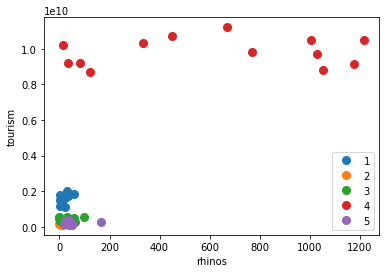

In [13]:
df = pd.read_csv('/Users/zoeyroberts/Documents/Spring 2022/Econs 525/Rhino Tourism Dataset.csv', \
                usecols = ['country', 'code', 'year', 'electric', 'exchangerate', 'fdi', \
                           'gdpcapita', 'immunization', 'rhinos', 'rural', 'stability', \
                           'tourism', 'trade', 'hdi'])
df = df.set_index(['country', 'year'], drop=False)
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.rhinos, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.ylabel('tourism')
plt.xlabel('rhinos')
plt.legend()

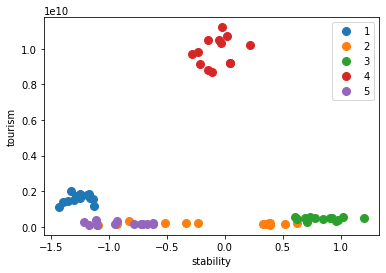

In [14]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.stability, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.ylabel('tourism')
plt.xlabel('stability')
plt.legend()

Text(0.5, 0, 'electric')

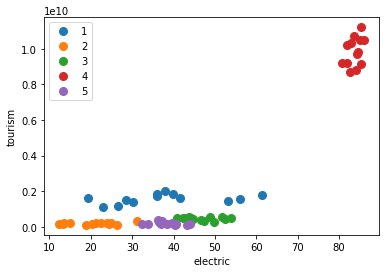

In [15]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.electric, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.legend()
plt.ylabel('tourism')
plt.xlabel('electric')

Text(0.5, 0, 'trade')

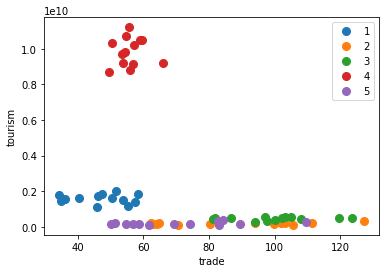

In [16]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.trade, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.legend()
plt.ylabel('tourism')
plt.xlabel('trade')

Text(0.5, 0, 'exchangerate')

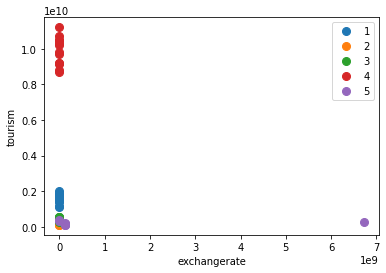

In [17]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.exchangerate, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.legend()
plt.ylabel('tourism')
plt.xlabel('exchangerate')

Text(0.5, 0, 'fdi')

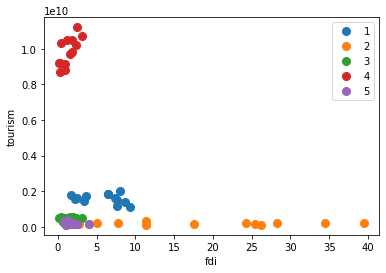

In [18]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.fdi, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.legend()
plt.ylabel('tourism')
plt.xlabel('fdi')

Text(0.5, 0, 'immunization')

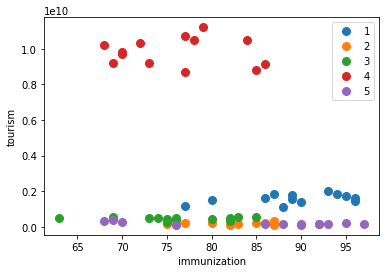

In [19]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.immunization, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.legend()
plt.ylabel('tourism')
plt.xlabel('immunization')

Text(0.5, 0, 'gdpcapita')

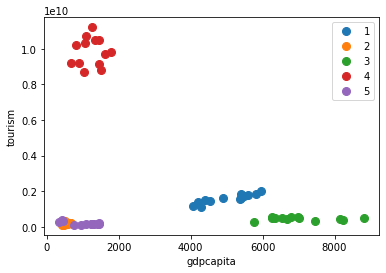

In [20]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.gdpcapita, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.legend()
plt.ylabel('tourism')
plt.xlabel('gdpcapita')

Text(0.5, 0, 'hdi')

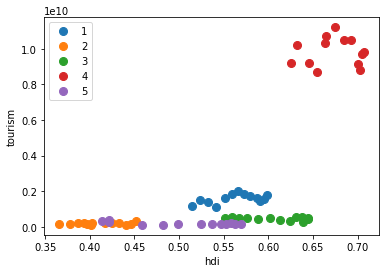

In [21]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.hdi, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.legend()
plt.ylabel('tourism')
plt.xlabel('hdi')

Text(0.5, 0, 'rural')

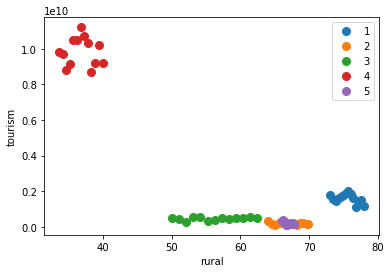

In [22]:
groups = df.groupby('code')
for name, group in groups:
    plt.plot(group.rural, group.tourism, marker='o', linestyle='', markersize=8, label=name)
plt.legend()
plt.ylabel('tourism')
plt.xlabel('rural')

In [23]:
df['tourism_ln'] = np.log(df['tourism'])
df['exchangerate_ln'] = np.log(df['exchangerate'])

In [24]:
# fixed effects model
mainreg = plm.PanelOLS.from_formula(
    formula='tourism_ln ~ electric + exchangerate_ln + fdi + gdpcapita + \
             rhinos + stability + trade + EntityEffects', data=df)
maincluster = mainreg.fit(cov_type='clustered', cluster_entity=True, debiased=False)
print(maincluster)

                          PanelOLS Estimation Summary                           
Dep. Variable:             tourism_ln   R-squared:                        0.3965
Estimator:                   PanelOLS   R-squared (Between):              0.0744
No. Observations:                  65   R-squared (Within):               0.3965
Date:                Wed, May 04 2022   R-squared (Overall):              0.0744
Time:                        11:14:49   Log-likelihood                    24.207
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.9753
Entities:                           5   P-value                           0.0002
Avg Obs:                       13.000   Distribution:                    F(7,53)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):         -4.993e+17
                            

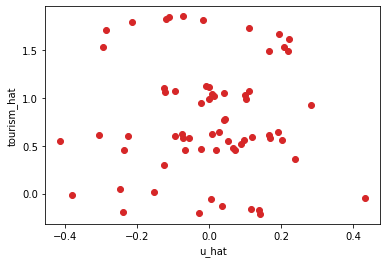

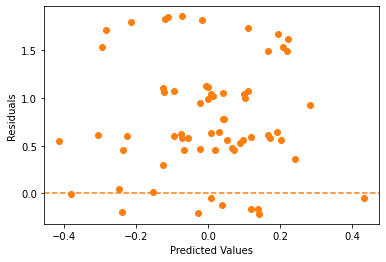

In [32]:
u_hat = maincluster.resids
tourism_hat = maincluster.fitted_values
plt.plot(u_hat, tourism_hat, color='tab:red', marker='o', linestyle='')
plt.ylabel('tourism_hat')
plt.xlabel('u_hat')
fig, ax = plt.subplots()
ax.scatter(u_hat, tourism_hat, color = 'tab:orange')
ax.axhline(0, color = 'tab:orange', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 10)
ax.set_ylabel('Residuals', fontsize = 10)
plt.show()

In [26]:
fe_df = pd.concat([df, u_hat], axis=1)
fe_df = fe_df.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(df['rhinos']).fillna(0)
white_test = het_white(fe_df['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test)))

{'LM-Stat': 2.448236078077526, 'LM p-val': 0.2940168974313446, 'F-Stat': 1.2133201953367188, 'F p-val': 0.30416716954949535}


/Users/zoeyroberts/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
breusch_pagan = het_breuschpagan(fe_df['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan)))

{'LM-Stat': 2.105654764290253, 'LM p-val': 0.14675551292635067, 'F-Stat': 2.1091920053087265, 'F p-val': 0.15137904895673263}


In [28]:
# fixed effects model
reg = plm.PanelOLS.from_formula(
    formula='tourism ~ electric + exchangerate + fdi + gdpcapita + \
             rhinos + stability + trade + EntityEffects', data=df)
cluster = reg.fit(cov_type='clustered', cluster_entity=True, debiased=False)
print(cluster)

                          PanelOLS Estimation Summary                           
Dep. Variable:                tourism   R-squared:                        0.0727
Estimator:                   PanelOLS   R-squared (Between):              0.2352
No. Observations:                  65   R-squared (Within):               0.0727
Date:                Wed, May 04 2022   R-squared (Overall):              0.2342
Time:                        11:14:54   Log-likelihood                   -1370.7
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      0.5938
Entities:                           5   P-value                           0.7580
Avg Obs:                       13.000   Distribution:                    F(7,53)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):         -1.151e+17
                            

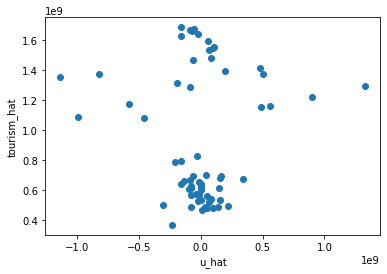

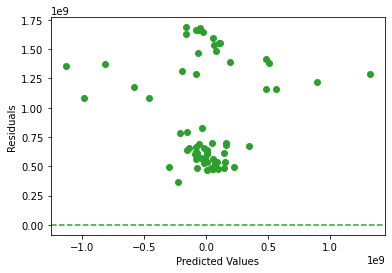

In [31]:
u_hat = cluster.resids
tourism_hat = cluster.fitted_values
plt.plot(u_hat, tourism_hat, color='tab:blue', marker='o', linestyle='')
plt.ylabel('tourism_hat')
plt.xlabel('u_hat')
fig, ax = plt.subplots()
ax.scatter(u_hat, tourism_hat, color = 'tab:green')
ax.axhline(0, color = 'tab:green', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 10)
ax.set_ylabel('Residuals', fontsize = 10)
plt.show()

In [31]:
fe_df = pd.concat([df, u_hat], axis=1)
fe_df = fe_df.drop(['year'], axis = 1).fillna(0)
exog = sm.tools.tools.add_constant(df['rhinos']).fillna(0)
white_test = het_white(fe_df['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, white_test)))

{'LM-Stat': 28.37404329385388, 'LM p-val': 6.896913578250057e-07, 'F-Stat': 24.01562774637003, 'F p-val': 1.8929722745556632e-08}


/Users/zoeyroberts/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
breusch_pagan = het_breuschpagan(fe_df['residual'], exog)
labels = ['LM-Stat', 'LM p-val', 'F-Stat', 'F p-val'] 
print(dict(zip(labels, breusch_pagan)))

{'LM-Stat': 19.538656209559008, 'LM p-val': 9.858439897853715e-06, 'F-Stat': 27.076527849162307, 'F p-val': 2.2705472499006754e-06}


In [33]:
# import rhino tourism dataset  
df = pd.read_csv('/Users/zoeyroberts/Documents/Spring 2022/Econs 525/Rhino Tourism Dataset.csv', \
                usecols = ['country', 'code', 'year', 'electric', 'exchangerate', 'fdi', \
                           'gdpcapita', 'immunization', 'hdi', 'rhinos', 'stability', \
                           'tourism', 'trade'])
df = df.set_index(['country', 'year'], drop=False)
print(df)

                country  code  year   electric  exchangerate       fdi  \
country  year                                                            
kenya    2006     kenya     1  2006  26.553055  7.210084e+01  7.625776   
         2007     kenya     1  2007  28.426634  6.731667e+01  7.570348   
         2008     kenya     1  2008  30.303398  6.917583e+01  8.718309   
         2009     kenya     1  2009  23.000000  7.735083e+01  9.274714   
         2010     kenya     1  2010  19.200000  7.923333e+01  2.515270   
...                 ...   ...   ...        ...           ...       ...   
zimbabwe 2014  zimbabwe     5  2014  32.300000  1.222375e+08  2.425173   
         2015  zimbabwe     5  2015  33.700000  1.222375e+08  1.999687   
         2016  zimbabwe     5  2016  39.676228  1.222375e+08  1.669274   
         2017  zimbabwe     5  2017  40.144283  1.222375e+08  1.746885   
         2018  zimbabwe     5  2018  40.616360  1.222375e+08  3.962704   

               gdpcapita    hdi  immu

In [34]:
df['tourism_ln'] = np.log(df['tourism'])
df['exchangerate_ln'] = np.log(df['exchangerate'])

In [35]:
fe_reg = plm.PanelOLS.from_formula(
    formula='tourism_ln ~ electric + exchangerate_ln + fdi + gdpcapita + \
             rhinos + stability + trade + EntityEffects', data=df)
fe_cluster = fe_reg.fit(cov_type='clustered', cluster_entity=True, debiased=False)
b_fe = fe_cluster.params
b_fe_cov = fe_cluster.cov
print(f'fe_cluster.summary: \n{fe_cluster.summary}\n')

re_reg = plm.RandomEffects.from_formula(
    formula='tourism_ln ~ electric + exchangerate_ln + fdi + gdpcapita + \
             rhinos + stability + trade', data=df)
re_results = re_reg.fit()
b_re = re_results.params
b_re_cov = re_results.cov
print(f're_results.summary: \n{re_results.summary}\n')

common_coef = set(fe_cluster.params.index).intersection(fe_cluster.params.index)
print(f'common_coef: {common_coef}\n')

b_diff = np.array(fe_cluster.params[common_coef] - re_results.params[common_coef])
df = len(b_diff)
b_diff.reshape((df, 1))
b_cov_diff = np.array(b_fe_cov.loc[common_coef, common_coef] -
                      b_re_cov.loc[common_coef, common_coef])
b_cov_diff.reshape((df, df))


stat = abs(np.transpose(b_diff) @ np.linalg.inv(b_cov_diff) @ b_diff)
pval = 1 - stats.chi2.cdf(stat, df)

print(f'stat: {stat}\n')
print(f'pval: {pval}\n')

fe_cluster.summary: 
                          PanelOLS Estimation Summary                           
Dep. Variable:             tourism_ln   R-squared:                        0.3965
Estimator:                   PanelOLS   R-squared (Between):              0.0744
No. Observations:                  65   R-squared (Within):               0.3965
Date:                Tue, May 03 2022   R-squared (Overall):              0.0744
Time:                        21:25:44   Log-likelihood                    24.207
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.9753
Entities:                           5   P-value                           0.0002
Avg Obs:                       13.000   Distribution:                    F(7,53)
Min Obs:                       13.000                                           
Max Obs:                       13.000   F-statistic (robust):         -4.993e+17
       